# Naive Bayes
[The sklearn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) contains a good explanation for Naive Bayes. It (naively) assumes conditional independence between all of the classes and tries to find the maximum likely y based on $P(y)\Pi_{i=1}^N P(x_i|y)$. We don't have specific classes to classify to, but given multiple headlines, we need to find the winner and thus the most likely one (accoording to th people that picked the winners) to be the most popular one. The different classes (y) are then the different headlines, so we can just keep P(y) out of the equation.

Since all the manually assigned labels are bernouilli distributed, we can use the [Bernoulli Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes). However, we still have the problem that we want the headline with the maximum probability to be the winner and not assign for each of them whether it's a winner or not (the classifications per test are dependent on each other).

## Train Data

In [1]:
from util import get_wpm_train_test
train_x, train_y, test_x, test_y = get_wpm_train_test(full_y_test=True)
train_x.head()

,Test,Headline ID,Headline,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
0,1,A,Barack en Michelle Obama laten dansmoves zien ...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,B,Barack en Michelle Obama gaan helemaal los tij...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2,A,Marc Coucke maakt opvallende keuze bij start v...,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,2,B,"Marc Coucke: ""Spelers van 10 miljoen? Neen, li...",1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
4,3,A,Maandag drukste dag van het jaar op Brussels A...,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1


In [2]:
from util import get_manually_labeled_features
train_x_features = get_manually_labeled_features(train_x)
train_x_features.head()

,Actief,Lang,Vragen,Interpunctie,Tweeledigheid,Emotie,Voorwaartse Verwijzing,Signaalwoorden,Lidwoorden,Adjectieven,Eigennamen,Betrekking,Voor+Achternaam,Cijfers,Quotes
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
4,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1


In [3]:
train_y_winner = train_y['Winner']
train_y_winner.head()

0    False
1     True
2     True
3    False
4     True
Name: Winner, dtype: bool

## Training

In [4]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()

model.fit(train_x_features, train_y_winner)

BernoulliNB()

Based on this model, we can try to predict the winner for each headline independently (so it's for example possible (even highly probable) that one test has multiple winners or none winner).

In [5]:
test_x_features = get_manually_labeled_features(test_x)
predictions = model.predict(test_x_features)
predictions[:5]

array([False, False,  True, False, False])

For example for the first headline (corresponding with row 0 and 1) we can see that there is no winner.

f-score: 0.4274368231046931
Confusion matrix: (TP: 1168, FP: 181, FN: 612, TN: 296)
Accuracy=64.86% (1464/2257)


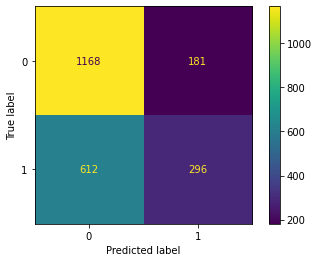

In [6]:
from util import print_evaluation
test_y_winner = test_y['Winner']
print_evaluation(test_y_winner, predictions)

The results are actually less bad than I expected (but still not good). Because all tests have at least one Winner=False and exactly one Winner=True, there are a lot more negative values than positive values (and because of this data imbalance, the chance of predicting winner as negative is of course also higher, which explains the higher than expected results).

In [7]:
# Create a new dataframe, being test_x with an extra column for the predictions
from util import get_label_columns
test_x_predictions = test_x.copy()
test_x_predictions['Winner'] = predictions
test_x_predictions = test_x_predictions.drop(get_label_columns(), axis=1) # drop some columns for readability
test_x_predictions.head()

,Test,Headline ID,Headline,Winner
0,1,A,Barack en Michelle Obama laten dansmoves zien ...,False
1,1,B,Barack en Michelle Obama gaan helemaal los tij...,False
2,2,A,Marc Coucke maakt opvallende keuze bij start v...,True
3,2,B,"Marc Coucke: ""Spelers van 10 miljoen? Neen, li...",False
4,3,A,Maandag drukste dag van het jaar op Brussels A...,False


In [15]:
# See how many rows with same id in "Test" have exactly one Winner=True row
exactly_one_winner_predicted_tests = test_x_predictions.groupby('Test').filter(lambda x: x['Winner'].sum() == 1)
# Only keep winner=true rows
exactly_one_winner_predicted_tests = exactly_one_winner_predicted_tests[exactly_one_winner_predicted_tests['Winner'] == True]
print(f"{len(exactly_one_winner_predicted_tests)} tests have exactly one winner predicted (out of {len(test_x.Test.unique())} tests)")

260 tests have exactly one winner predicted (out of 909 tests)


# Warning: There is still a bug in the code below that I haven't fixed yet. (for tomorrow)

Let's see how many of those are correct:

In [16]:
winners_only = test_x_predictions[test_x_predictions['Winner'] == True]
test_y_winner_only = test_y[test_y['Winner'] == True]
# Get how many (Test, Headline ID) pairs of winners only are in the test_y_winner_only dataframe
winners_only_in_test_y_winner_only = winners_only.merge(test_y_winner_only, on=['Test', 'Headline ID'], how='inner')
print(f"{len(winners_only_in_test_y_winner_only)} winners are predicted correctly")

296 winners are predicted correctly


This is an extremly low number of tests.

In [ ]:
# Usefull link for tomorrow: https://stackoverflow.com/questions/21088853/how-to-get-nbest-predictions-from-sklearn-naive-bayes-classifier-python